In [ ]:
from fastai import *
from fastai.text import * 
from pathlib import Path
import pandas as pd
import numpy as np
import re

In [ ]:
import fastai
fastai.__version__

'1.0.61'

In [ ]:
!pip install fastai==1.0.61
!pip install -U spacy==2.2.4

In [ ]:
path = Path('./data')
trainfile = 'semeval2016-task6-trainingdata.txt'
testfile = 'SemEval2016-Task6-subtaskA-testdata.txt'

In [ ]:
def clean_ascii(text):
    # function to remove non-ASCII chars from data
    return ''.join(i for i in text if ord(i) < 128)

In [ ]:
train_orig = pd.read_csv(path/trainfile, delimiter='\t', header=0, encoding = "latin-1")

In [ ]:
# Check that the latest 1.0.0 build of PyTorch has been installed 
# alongside fastai
import torch
print("Cuda available" if torch.cuda.is_available() is True else "CPU")
print("PyTorch version: ", torch.__version__)

CPU
PyTorch version:  1.10.0


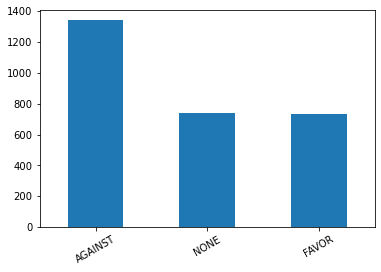

In [ ]:
# Plot value counts for rach stance in the dataset
train_orig['Stance'].value_counts().plot.bar(rot=30);

In [ ]:
print("SemEval 2016 Task 6 (subtask A) Tweet topics are:\n")
print("------------------------------------------")
for item in train_orig['Target'].unique():
    print(item)

SemEval 2016 Task 6 (subtask A) Tweet topics are:

------------------------------------------
Atheism
Climate Change is a Real Concern
Feminist Movement
Hillary Clinton
Legalization of Abortion


In [ ]:
train_orig['Tweet'] = train_orig['Tweet'].apply(clean_ascii)

In [ ]:
train = pd.concat([train_orig['Stance'], train_orig['Tweet']], axis=1)
train.tail()

,Stance,Tweet
2809,AGAINST,"There's a law protecting unborn eagles, but no..."
2810,AGAINST,I am 1 in 3... I have had an abortion #Abortio...
2811,AGAINST,How dare you say my sexual preference is a cho...
2812,AGAINST,"Equal rights for those 'born that way', no rig..."
2813,AGAINST,#POTUS seals his legacy w/ 1/2 doz wins. The #...


In [ ]:
# Write train to csv
train.to_csv(path/'train.csv', index=False, header=False)

In [ ]:
# Language model data
data_lm = TextLMDataBunch.from_csv(path, 'train.csv', min_freq=1)

/opt/anaconda3/lib/python3.9/site-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(a, dtype=dtype, **kwargs)


In [ ]:
# Save the language and classifier model data for re-use
data_lm.save()

In [ ]:
data_lm.show_batch()

idx,text
0,"women more equal than men . xxmaj go read "" xxmaj animal xxmaj farm # semst xxbos xxmaj china , i had plans to work on other things today . xxmaj rude . # euchina # semst xxbos xxmaj and stay in your houses and do not display yourselves like that of the times of ignorance . "" [ xxmaj quran 33:33 ] . # islam # semst xxbos #"
1,. # bible # semst xxbos xxmaj my liberty depends on you being free too . xxmaj president xxmaj obama # semst xxbos @anitafinlay @politico xxmaj hillary 's doing the right thing -- staying focus on her campaign . # semst xxbos xxmaj all i 'm doing is reading xxup gg tweets and getting angrier . f xxrep 11 u ck men are privileged . xxmaj time for bed .
2,"please go away . # nycpride # xxup nyc # semst xxbos xxmaj headed to xxmaj chester , xxup sc for a big hillary canvass ! xxmaj join me . xxmaj wylie park 11 - 3 # semst xxbos xxmaj thankful for another day of this awesome life xxmaj god has given us :) # peace # thankful # goodfather # abundant # joy # life # goodness # semst"
3,"# semst xxbos @andybud_o xxmaj the xxmaj mito xxmaj eve model does not explicit prove 1 ancestor , it narrows down similarities to a matter of a degree ... # semst xxbos xxmaj you 'd be blind not to see that this amazing moment in time is not being celebrated by religious zealots . # lovewins # semst xxbos xxmaj people who have been pregnant can be pro choice ."
4,"president # unitedstates world is success of women in world # semst xxbos xxmaj have you sensed the summons to your journey ? # spirituality # semst xxbos xxmaj kudos to the mentality that believes people who are dumb enough to not use protection are ' mature enough ' to take care of a baby . # semst xxbos xxmaj yes , do tell xxup us , name one of"


In [ ]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.1)

In [ ]:
list(learn.model.children())

[AWD_LSTM(
   (encoder): Embedding(7960, 400, padding_idx=1)
   (encoder_dp): EmbeddingDropout(
     (emb): Embedding(7960, 400, padding_idx=1)
   )
   (rnns): ModuleList(
     (0): WeightDropout(
       (module): LSTM(400, 1152, batch_first=True)
     )
     (1): WeightDropout(
       (module): LSTM(1152, 1152, batch_first=True)
     )
     (2): WeightDropout(
       (module): LSTM(1152, 400, batch_first=True)
     )
   )
   (input_dp): RNNDropout()
   (hidden_dps): ModuleList(
     (0): RNNDropout()
     (1): RNNDropout()
     (2): RNNDropout()
   )
 ),
 LinearDecoder(
   (decoder): Linear(in_features=400, out_features=7960, bias=True)
   (output_dp): RNNDropout()
 )]

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


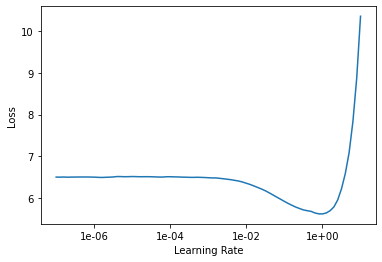

In [ ]:
learn.lr_find(start_lr=1e-8, end_lr=1e2)
learn.recorder.plot()

In [ ]:
learn = language_model_learner(data_lm,AWD_LSTM , 
                               drop_mult=0.5)
learn.fit_one_cycle(cyc_len=1, max_lr=1e-3, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,6.518742,5.585448,0.174107,01:33


In [ ]:
learn.unfreeze()
learn.fit_one_cycle(cyc_len=20, max_lr=1e-3, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,5.945930,4.754190,0.233594,02:23
1,5.589841,4.586810,0.241462,02:16
2,5.337420,4.541716,0.260100,02:10
3,5.128935,4.515111,0.270871,02:19
4,4.944312,4.503293,0.273828,02:09
5,4.731821,4.346455,0.304353,02:11
6,4.485592,4.317403,0.305357,02:11
7,4.242664,4.325276,0.305859,02:20
8,4.002929,4.357602,0.306864,02:18
9,3.766145,4.421503,0.306027,02:17


In [ ]:
# Save the fine-tuned encoder
learn.save_encoder('ft_enc')

In [ ]:
for item in train_orig.Target.unique():
    print(item)

Atheism
Climate Change is a Real Concern
Feminist Movement
Hillary Clinton
Legalization of Abortion


In [ ]:
topic = "Feminist Movement"

In [ ]:
# Get only those tweets that pertain to a single topic in the training data
train_topic = train.loc[train_orig['Target'] == topic]

In [ ]:
# Write train to csv
train_topic.to_csv(path/'train_topic.csv', index=False, header=False)

In [ ]:
# Classifier model data
data_clas = TextClasDataBunch.from_csv(path, 'train_topic.csv', vocab=data_lm.train_ds.vocab,
                                       min_freq=1, bs=32)
data_clas.save()

/opt/anaconda3/lib/python3.9/site-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(a, dtype=dtype, **kwargs)


/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [ ]:
learn = text_classifier_learner(data_clas,AWD_LSTM, drop_mult=0.5)
learn.load_encoder('ft_enc')
learn.freeze()

/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' whe

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


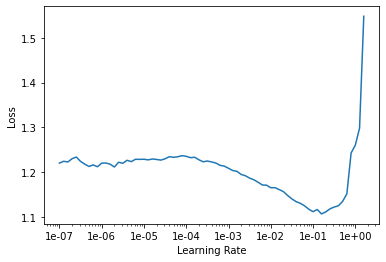

In [ ]:
learn.lr_find(start_lr=1e-8, end_lr=1e2)
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(cyc_len=1, max_lr=1e-3, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.197081,1.061932,0.473684,02:16


/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [ ]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-4,1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.147390,0.892685,0.571429,02:19


/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [ ]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(1e-5,5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.954051,0.899554,0.593985,02:24


/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [ ]:
learn.unfreeze()
learn.fit_one_cycle(4, slice(1e-5,1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.838741,0.879664,0.609023,02:46
1,0.831243,0.877711,0.548872,02:50
2,0.770923,0.875165,0.556391,02:45
3,0.738000,0.868368,0.578947,02:44


/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' whe

In [ ]:
# get predictions
preds, targets = learn.get_preds()
predictions = np.argmax(preds, axis=1)
pd.crosstab(predictions, targets)

col_0,0,1,2
row_0,,,
0,47,21,10
1,14,18,3
2,4,4,12


In [ ]:
test = pd.read_csv(path/testfile, delimiter='\t', header=0, encoding = "latin-1")
test = test.drop(['ID'], axis=1)
# test['Tweet'] = test['Tweet'].apply(clean_ascii)
test.head()

,Target,Tweet,Stance
0,Atheism,He who exalts himself shall be humbled; a...,UNKNOWN
1,Atheism,RT @prayerbullets: I remove Nehushtan -previou...,UNKNOWN
2,Atheism,@Brainman365 @heidtjj @BenjaminLives I have so...,UNKNOWN
3,Atheism,#God is utterly powerless without Human interv...,UNKNOWN
4,Atheism,@David_Cameron Miracles of #Multiculturalism...,UNKNOWN


In [ ]:
test_pred = test[['Target', 'Tweet']]
test_pred = test_pred.loc[test_pred['Target'] == topic]
test_pred.tail()

,Target,Tweet
669,Feminist Movement,@Maisie_Williams is our hero with her #LikeAGi...
670,Feminist Movement,"Rather be an ""ugly"" feminist then be these sad..."
671,Feminist Movement,iamNovaah: RT ChrzOC: Bitches be running wild....
672,Feminist Movement,@angerelle you disagree that people should str...
673,Feminist Movement,#Rapeculture is basically a FABLE. It has almo...


In [ ]:
test_pred['Stance'] = test_pred['Tweet'].apply(lambda row: str(learn.predict(row)[0]))

In [ ]:
test_pred.tail()

,Target,Tweet,Stance
669,Feminist Movement,@Maisie_Williams is our hero with her #LikeAGi...,NONE
670,Feminist Movement,"Rather be an ""ugly"" feminist then be these sad...",AGAINST
671,Feminist Movement,iamNovaah: RT ChrzOC: Bitches be running wild....,NONE
672,Feminist Movement,@angerelle you disagree that people should str...,FAVOR
673,Feminist Movement,#Rapeculture is basically a FABLE. It has almo...,AGAINST


In [ ]:
test_pred.to_csv(path/'eval'/'predicted.txt', sep='\t', index=True,
                 header=['Target', 'Tweet', 'Stance'], index_label='ID')